In [1]:
import math
import pydot
import numpy as np
from IPython.display import HTML, display, SVG
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve
import os
from pydrake.multibody.tree import QuaternionFloatingJoint
#if running_as_notebook:
#    mpld3.enable_notebook()

%matplotlib widget

import matplotlib.pyplot as plt
meshcat = StartMeshcat()

/home/vince-cs/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
INFO:drake:Meshcat listening for connections at http://localhost:7000


In [2]:

def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
    #plant = builder.AddSystem(MultibodyPlant(0.0))
    #scene_graph = builder.AddSystem(SceneGraph())
    parser = Parser(plant)
    
    # Your relative path
    relative_path = "quad-v4/quad-v4.urdf"
    # Convert to an absolute path
    absolute_path = os.path.abspath(relative_path)
    
    # Use the absolute path here
    (model_instance,) = parser.AddModels(absolute_path)
    
    # Adding QuaternionFloatingJoint
    frame_on_parent = plant.world_frame()
    frame_on_child = plant.GetFrameByName("quad_v4", model_instance)

    #rotation = RigidTransform.RollPitchYaw(0, 0, np.pi / 4)  # Rotate 45 degrees about Z

    plant.AddJoint(
        QuaternionFloatingJoint(
            name="BaseJoint",
            frame_on_parent=frame_on_parent,  # Corrected parameter name
            frame_on_child=frame_on_child,  # Corrected parameter name
            angular_damping=0.0,  # Optional, showing how to use it
            translational_damping=0.0, # Optional, showing how to use it
        )
    )
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat
    )

    body_index = plant.GetBodyByName("quad_v4").index()

    L = 0.395 #meters arm length
    #prop_offsets = [0.21507, 0.27856, 0.09495]
    prop_pos = {'x' : 0.21507, 'y' : 0.27856, 'z' : 0.09495}

    #plot_propeller_positions(prop_pos)

    """
    Pydrake uses the following convention for the propeller inputs:

    thrust_ratio * command Newtons, where kf is thrust ratio, I know my max thrust is 10.5N (10kg thrust)

    by setting thrust_ratio = 1 / 10.5, I can input normalized thrust commands to the propellers
    """
    kF = 10.5

    """
    Pydrake uses the following convention for toque inputs:
    moment_ratio * command Newton-meters.

    we estimate 0.7 Nm as the max torque of the propellers
    """
    kM = 0.0245  #estimate torque constant (torque = kM * angularvelocity^2)

    """
    prop_pos['x'], prop_pos['y'], prop_pos['z'] are the offsets of the propellers from the center of mass
    -prop_pos['x'], prop_pos['y'], prop_pos['z'] are the offsets of the propellers from the center of mass
    -prop_pos['x'], -prop_pos['y'], prop_pos['z'] are the offsets of the propellers from the center of mass
    prop_pos['x'], -prop_pos['y'], prop_pos['z'] are the offsets of the propellers from the center of mass

    """
    prop_info = [
        PropellerInfo(body_index, RigidTransform([prop_pos['x'], prop_pos['y'], prop_pos['z']]), kF, kM),
        PropellerInfo(body_index, RigidTransform([-prop_pos['x'], prop_pos['y'], prop_pos['z']]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-prop_pos['x'], -prop_pos['y'], prop_pos['z']]), kF, kM),
        PropellerInfo(body_index, RigidTransform([prop_pos['x'], -prop_pos['y'], prop_pos['z']]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )

    #quad_base = plant.GetModelInstanceByName("body")

    """
    Inputs are the propeller commands between 0 and 1, 0 being no thrust and 1 being 10.5N of thrust
    """
    builder.ExportInput(propellers.get_command_input_port(), "u")
    builder.ExportOutput(plant.get_state_output_port(), "state")


    return builder.Build(), plant


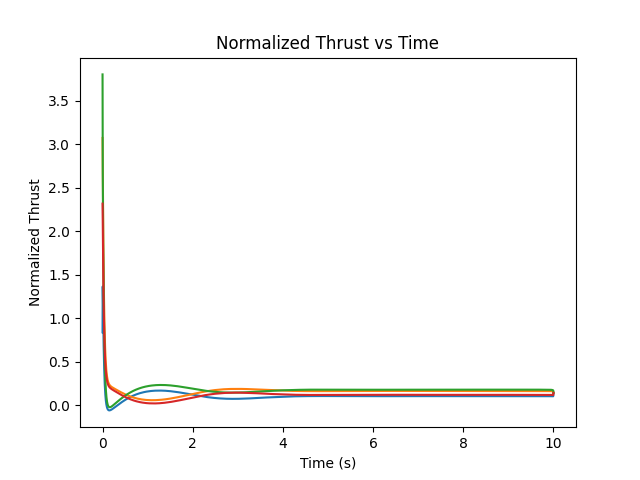

In [3]:
from pydrake.all import ConstantVectorSource
from pydrake.systems.controllers import MakeFiniteHorizonLinearQuadraticRegulator
from pydrake.multibody.optimization import StaticEquilibriumProblem
from pydrake.systems.primitives import LogVectorOutput


def SanityHoverCheckLQR():
    quadrotor_diagram, quadrotor_plant = MakeMultibodyQuadrotor()
    # Create System Context
    target_scenerio = quadrotor_diagram.CreateDefaultContext()

    #['qw', 'qx', 'qy', 'qz', 'x', 'y', 'z', 'wx', 'wy', 'wz', 'vx', 'vy', 'vz']
    nominal_hover_state = np.array([1, 0, 0, 0, 1, 1, 5, 0, 0, 0, 0, 0, 0])
    target_scenerio.SetContinuousState(nominal_hover_state[:])
    
    """
    Thrust to linearize about
    """
    # Calculate nominal input
    mass = quadrotor_plant.CalcTotalMass(quadrotor_plant.GetMyContextFromRoot(target_scenerio))
    gravity = quadrotor_plant.gravity_field().gravity_vector()
    nominal_input = [(-mass * gravity[2]) / 4] * 4 #[CW, CW2, CCW, CCW2] CW - TOP RIGHT | CW2 - BOTTOM LEFT || CCW - TOP LEFT | CCW2 BOTTOM RIGHT
    nominal_input = np.array(nominal_input)
    nominal_input = nominal_input / 10.5
    #quadrotor.get_input_port().FixValue(target_scenerio, nominal_input)
    #nominal_input = np.array([0.15, 0.15, 0.15, 0.15])
    quadrotor_diagram.get_input_port().FixValue(target_scenerio, nominal_input[:])
    
    lqr_control = MakeFiniteHorizonLinearQuadraticRegulator(quadrotor_diagram, target_scenerio, 0, 10, Q=np.eye(13), R=np.eye(4))

    simulation_builder = DiagramBuilder()

    
    #constant_actuation = simulation_builder.AddSystem(ConstantVectorSource(nominal_input))
    controller = simulation_builder.AddSystem(lqr_control)
    actuation_logger = LogVectorOutput(controller.get_output_port(0), simulation_builder)

    quadrotor = simulation_builder.AddSystem(quadrotor_diagram)
    simulation_builder.Connect(controller.get_output_port(0), quadrotor.get_input_port(0))
    simulation_builder.Connect(quadrotor.get_output_port(0), controller.get_input_port(0))
    #simulation_builder.AddSystem(lqr_control)
    #simulation_builder.AddSystem(quadrotor_diagram)

    simulation_diagram = simulation_builder.Build()

    return simulation_diagram, actuation_logger


def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    return simulator

def run_simulation(sim_time_step, finish_time, diagram):
    simulator = initialize_simulation(diagram)
    meshcat.StartRecording()
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()
    return simulator

sim_diagram, actuation_logs = SanityHoverCheckLQR()

simulator = run_simulation(sim_time_step = 0.1, finish_time=10, diagram=sim_diagram)

sim_context_history = simulator.get_mutable_context()

log_data = actuation_logs.FindLog(sim_context_history)
time = log_data.sample_times()
state = log_data.data()

for i in range(4):
    plt.plot(time, state[i], label=f"Propeller {i+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Thrust")
    plt.title("Normalized Thrust vs Time")
    plt.grid()
plt.show()


## Rate controller and mixer

In [4]:
import numpy as np
from pydrake.systems.framework import LeafSystem_, BasicVector_, PublishEvent, TriggerType
from pydrake.all import AbstractValue
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.systems.controllers import PidController

@TemplateSystem.define("AttitudeRateController_")
def AttitudeRateController_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, Kp, Ki, Kd, converter=None):
            LeafSystem_[T].__init__(self, converter)

            # Input port - angular rates 
            self.DeclareAbstractInputPort("angular_rates", AbstractValue.Make(T())) 

            # Output port - body torque commands
            self.DeclareAbstractOutputPort("torque_commands", AbstractValue.Make(T()))

            # Number of control axes (roll, pitch, yaw = 3)
            self._num_axes = 3  

            # Create PID controllers for each axis
            self._controllers = []
            self._initialize_controllers(Kp, Ki, Kd) 

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, other.Kp, other.Ki, other.Kd, converter=converter)

        def _initialize_controllers(self, Kp, Ki, Kd):
            """Helper function to create PID controllers based on provided gains"""
            if len(Kp) != self._num_axes or len(Ki) != self._num_axes or len(Kd) != self._num_axes:
                raise ValueError("Gain vectors (Kp, Ki, Kd) must have the same length as the number of control axes.")

            for i in range(self._num_axes):
                self._controllers.append(PidController(Kp[i], Ki[i], Kd[i]))

        def DoCalcVectorOutput(self, context, angular_rates, time, output):
            angular_rates_value = angular_rates.get_value()

            # Assuming angular_rates.size() == self._num_axes
            control_commands = np.zeros(self._num_axes) 
            for i in range(self._num_axes):
                error = 0.0 - angular_rates_value[i]  # Desired angular rate is 0
                control_commands[i] = self._controllers[i].CalcOutput(context, error)

            output.SetFromVector(control_commands)  

    return Impl

@TemplateSystem.define("QuadrotorMotorMixer_")
def QuadrotorMotorMixer_(T):

    class Impl(LeafSystem_[T]):
        """
        This class implements a motor mixer for a quadrotor. It takes a desired collective 
        thrust and torques (roll, pitch, yaw) as inputs and calculates the individual motor 
        commands required to achieve those values. 
        """
        def _construct(self, converter=None):
            """
            Initializes the motor mixer with parameters and input/output ports.

            Args:
                converter: (Optional) For use with the TemplateSystem.
            """
            LeafSystem_[T].__init__(self, converter)

            # Parameters
            self.arm_length = 0.5  # Example - Set your actual arm length [m]
            self.max_thrust = 10.0  # Example - Set your max single motor thrust

            # Input Ports
            self.DeclareVectorInputPort("collective_normalized_thrust", BasicVector_[T](1))
            self.DeclareVectorInputPort("torque", BasicVector_[T](3))  # Roll, pitch, yaw torque

            # Output Port (Normalized motor commands)
            self.DeclareVectorOutputPort("motor_thrusts", BasicVector_[T](4), self.CalcOutput)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CalcOutput(self, context, output):
            """
            Calculates the individual motor thrusts required to achieve the desired
            collective thrust and torques.

            Args:
                context: The context for the LeafSystem evaluation.
                output: The output vector where the calculated thrusts will be stored
            """
            collective_thrust = self.get_input_port(0).Eval(context)[0]
            total_torque = self.get_input_port(1).Eval(context)[2]  # Assumes yaw torque

            # Pre-calculate constants
            k1 = collective_thrust * self.max_thrust / 4
            k2 = total_torque / (2 * self.arm_length)

            # Calculate individual motor thrusts (normalized)
            motor_thrusts = np.array([
                k1 + k2,  # Front right motor
                k1 - k2,  # Front left motor
                k1 - k2,  # Back left motor
                k1 + k2   # Back right motor
            ])

            # Ensure thrusts are within the normalized range [0, 1]
            motor_thrusts = np.clip(motor_thrusts, 0, 1) 

            output.SetFromVector(motor_thrusts)

    return Impl


## LQR Dynamics

In [5]:
@TemplateSystem.define("QuaternionDynamicsSystem_")
def QuaternionDynamicsSystem_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # Declare system state: assuming 10 states as per your dynamics
            self.DeclareContinuousState(10)
            # Input port for control inputs: assuming 4 inputs
            self.DeclareVectorInputPort("u", BasicVector_[T](4))
            # Output port for system state
            self.DeclareVectorOutputPort("x", BasicVector_[T](10), self.CopyStateOut)

        def _construct_copy(self, other, converter=None):
            # Constructor used for scalar conversion
            Impl._construct(self, converter=converter)

        def CopyStateOut(self, context, output):
            # Copy the state to the output port
            x = context.get_continuous_state_vector().CopyToVector()
            output.SetFromVector(x)

        def DoCalcTimeDerivatives(self, context, derivatives):
            x = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            # Calculate dynamics here. Placeholder for actual dynamics calculation
            dx_dt = self.calculate_dynamics(x, u)
            derivatives.get_mutable_vector().SetFromVector(dx_dt)
    
        def calculate_dynamics(self, x, u):
            # Extract the state components
            p = x[:3]  # Position (px, py, pz)
            q = x[3:7]  # Orientation quaternion (qw, qx, qy, qz)
            v = x[7:]  # Velocity (vx, vy, vz)
        
            # Extract control inputs
            omega_des = u[:3]  # Desired body rates (wx_des, wy_des, wz_des)
            c_des = u[3]  # Desired thrust
        
            # Construct the quaternion from state
            q_w, q_x, q_y, q_z = q
        
            # Quaternion kinematics
            Qx = np.array([
                [ q_w, -q_x, -q_y, -q_z],
                [ q_x,  q_w, -q_z,  q_y],
                [ q_y,  q_z,  q_w, -q_x],
                [ q_z, -q_y,  q_x,  q_w]
            ])

            augmented_omega = np.concatenate(([0], omega_des)).reshape(4,)
            # Quaternion derivative
            q_dot = 0.5 * Qx @ augmented_omega
        
            # Compute the gravity vector
            g = 9.81  # Acceleration due to gravity
            g_vec = np.array([0, 0, -g])
        
            # Rotation matrix from quaternion
            R = np.array([
                [1 - 2*q_y**2 - 2*q_z**2, 2*q_x*q_y - 2*q_z*q_w,     2*q_x*q_z + 2*q_y*q_w],
                [2*q_x*q_y + 2*q_z*q_w,     1 - 2*q_x**2 - 2*q_z**2, 2*q_y*q_z - 2*q_x*q_w],
                [2*q_x*q_z - 2*q_y*q_w,     2*q_y*q_z + 2*q_x*q_w,     1 - 2*q_x**2 - 2*q_y**2]
            ])
        
            # Velocity dynamics
            v_dot = g_vec + R @ np.array([0, 0, c_des])
            dx_dt = np.concatenate((v, q_dot, v_dot))
        
            return dx_dt

    return Impl

In [6]:

from pydrake.systems.framework import LeafSystem, BasicVector

class LqrController(LeafSystem):
    def __init__(self, input_size, state_size, update_period, Q, R):
        LeafSystem.__init__(self)
        self.input_size = input_size
        self.state_size = state_size
        self.K = np.zeros((input_size, state_size))

        # Input ports
        self.DeclareVectorInputPort("state", BasicVector(state_size))
        self.DeclareVectorOutputPort("control_output", BasicVector(input_size), self.CalcOutput)

        # Internal update mechanism
        self.update_event = self.DeclarePeriodicEvent(
            period_sec=update_period,
            offset_sec=0.,
            callback=self.UpdateK
        )

        # Store Q and R for LQR calculation
        self.Q = Q
        self.R = R

    def UpdateK(self, context, event):
        # Get system reference (assuming it's what you linearize around)
        system_context = self.GetMyContextFromRoot(context)  
        state_ref = system_context.get_continuous_state_vector().CopyToVector()
        # ... (Get the reference input if needed) ...
        
        # Linearization and LQR calculation
        A, B = Linearize(system_ref, input_ref)  # Adapt your linearization appropriately
        self.K, P = CalculateLqrGains(A, B, self.Q, self.R) 

    def CalcOutput(self, context, output):
        state = self.get_input_port().Eval(context)
        u_desired = ...  # Some desired input for the system 
        u = -self.K @ state + u_desired 
        output.SetFromVector(u) 

## Linking Control Together

In [7]:
from pydrake.systems.framework import DiagramBuilder, BasicVector, VectorBase
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController


from pydrake.systems.scalar_conversion import TemplateSystem


@TemplateSystem.define("PositionVelocityAccelerationController_")
def PositionVelocityAccelerationController_(T):
    """Implements a combined position, velocity, and acceleration controller
    """
    class Impl(LeafSystem_[T]):
        def _construct(self, position_gains, velocity_gains, acceleration_gains):
            LeafSystem_[T].__init__(self)
            self.DeclarePeriodicDiscreteUpdateEvent(period_sec=0.02) # 50Hz update rate
            self.position_gains = position_gains
            self.velocity_gains = velocity_gains
            self.acceleration_gains = acceleration_gains

            # Input ports
            self.DeclareVectorInputPort("desired_position", BasicVector_[T](3))
            self.DeclareVectorInputPort("measured_position", BasicVector_[T](3))
            self.DeclareVectorInputPort("measured_velocity", BasicVector_[T](3))

            # Output port (desired accelerations)
            self.DeclareVectorOutputPort("desired_acceleration", BasicVector_[T](3), self.CalcOutput)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        
        def CalcOutput(self, context, output):
            desired_pos = self.get_input_port(0).Eval(context)
            measured_pos = self.get_input_port(1).Eval(context)
            measured_vel = self.get_input_port(2).Eval(context)

            # Calculate position error
            pos_error = desired_pos - measured_pos

            # Implement a simple proportional controller for position error
            desired_vel = self.position_gains * pos_error

            # Calculate velocity error (using previously desired velocity)
            vel_error = desired_vel - measured_vel

            # Calculate desired acceleration
            desired_acceleration = self.velocity_gains * vel_error + self.acceleration_gains * pos_error

            output.SetFromVector(desired_acceleration)